# Introduction

This TP3 is based on the previous TP2 where we considered the `census` dataset and applied the `LogisticRegression`.

Prior to that you should have inspected the data.

In particular, you may have
- used the raw data,
- created groups,
- or even new features

to simplify the learning phase as well as the interpretation of your output.

**Based on this important phase of data visualization/inspection/description... we are going to apply some new classification techniques on the same dataset, namely**

1. Decision trees through `DecisionTreeClassifier`
2. Support Vector Machines through `SVC`

**Today, your missions are the following:**

1. Practice your basics in the companion notebook `Toy_examples`.
2. Create a baseline perfomance on the `census` data with the classifiers of the day.
3. Tune the parameters to obtain good classification perfomances using `GridSearchCV`.
4. Select between the 2 models based on the classification error on the test set
5. Display both the ROC curves and compute the corresponding AUCs.

**Hints:**
- 💣 Use notebook `Toy_example` 💣
- Don't forget to `MAJ + Tab*2`!
- `sklearn` objects have the same standardized methods as you saw before
    - `.fit`
    - `.predict/predict_proba`
    - `.score` 
    - ...
- You search engine is a nice asset... you can find inspiration in examples of other people

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Load-packages-and-related-objects" data-toc-modified-id="Load-packages-and-related-objects-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load packages and related objects</a></span></li><li><span><a href="#Load-and-prepare-the-data" data-toc-modified-id="Load-and-prepare-the-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load and prepare the data</a></span></li></ul></li><li><span><a href="#Back-to-Logistic-Regression" data-toc-modified-id="Back-to-Logistic-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Back to Logistic Regression</a></span></li><li><span><a href="#Baselines-for-this-TP" data-toc-modified-id="Baselines-for-this-TP-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Baselines for this TP</a></span></li><li><span><a href="#Decision-Trees" data-toc-modified-id="Decision-Trees-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Decision Trees</a></span><ul class="toc-item"><li><span><a href="#Vizualization-of-shallow-(low-depth)-trees" data-toc-modified-id="Vizualization-of-shallow-(low-depth)-trees-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Vizualization of shallow (low depth) trees</a></span></li><li><span><a href="#Bias-variance-tradeoff" data-toc-modified-id="Bias-variance-tradeoff-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Bias-variance tradeoff</a></span></li><li><span><a href="#Optimization-of-the-classifier-with-respect-to-classification-error" data-toc-modified-id="Optimization-of-the-classifier-with-respect-to-classification-error-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Optimization of the classifier with respect to classification error</a></span><ul class="toc-item"><li><span><a href="#Preliminary" data-toc-modified-id="Preliminary-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Preliminary</a></span></li><li><span><a href="#Let's-practice" data-toc-modified-id="Let's-practice-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Let's practice</a></span></li></ul></li></ul></li><li><span><a href="#SVMs" data-toc-modified-id="SVMs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>SVMs</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Load packages and related objects

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# use pandas to play with dataset
import pandas as pd

# use seaborn to display data
import seaborn as sns

# use sklearn to practice ML
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

# Algorithms of the day
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#To visualize trees 
import graphviz
from sklearn.tree import export_graphviz

## Load and prepare the data

We consider the same pipeline as in TP2.

But we take a smaller fraction of the data to train the models,
mainly because SVMs scale poorly with the size of the training set!

In [2]:
data = pd.read_csv('census.csv', na_values='?')

# Drop some sensitive data
data.drop(columns=['fnlwgt', 'native.country'], inplace=True)

# Drop missing values
data.dropna(inplace=True) 

X_data = data.drop(columns='income', axis=1)

# Construct dummy variables for categorical variables
categorical_features = ['workclass', 'education', 'marital.status',
                        'occupation', 'relationship', 'race', 'sex']
X_data = pd.get_dummies(X_data, columns=categorical_features, drop_first=True)

# Convert string label to 0, 1
y_data = LabelEncoder().fit_transform(data['income'])

# Split train/test
test_frac = 2/3 # Fraction of the data set to consider as test set

X_train, X_test,\
y_train, y_test = train_test_split(X_data, y_data,
                                   test_size=test_frac,
                                   shuffle=True, # Shuffle the data points before split
                                   stratify=y_data, # Respect the proportion of classes
                                   random_state=123) # To compare your performance to your neighbor's

# Back to Logistic Regression

Here you are simply given an example of code to:

- instanciate the model with `sklearn`
- build the corresponding ROC curve and compute the corresponding AUC
- plot the ROC curve

Rember that the underlying optimization problem solved by `sklearn` reads in this case

$$
\min_{w, c} \frac{1}{2}w^T w + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1)
$$

so you can take $C\gg 1$ to work as if there was no regularization: the version of `LogisticRegression` you were taught in class.

###### Instanciate/train/score the model

a. Choose 3 parameters of the `LogisticRegression` object and describe them

In [3]:
log_reg = LogisticRegression(C=1e5)

log_reg.fit(X_train, y_train)

test_accuracy = log_reg.score(X_test, y_test)

/home/dbaudry/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


###### Build the Receiver Operating Characteristic curve

b. Describe in a few words how the ROC curve is constructed

In [4]:
# 1: predict the probability to be classified as 1
proba_pred_1 = log_reg.predict_proba(X_test)[:,1]

# 2: compute false/true positive rates obtained by moving the detection threshold
fpr, tpr, tresh = roc_curve(y_test, proba_pred_1)

# Compute the Area Under the Curve
eval_auc = auc(fpr, tpr)

###### Plot the ROC curve

c. Comment on the shape of the ROC curve.

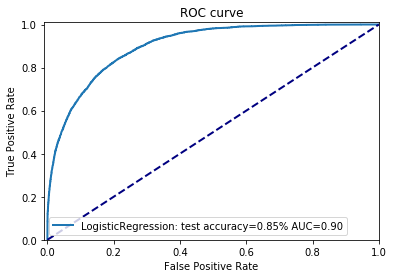

In [5]:
fig, ax = plt.subplots()

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Plot the ROC curve
lab = 'LogisticRegression: test accuracy={:.2f}% AUC={:.2f}'.format(test_accuracy, eval_auc)
ax.plot(fpr, tpr,
        lw=2, 
        label=lab) 

# Plot the ROC curve associated to a coin flip
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])

plt.legend(loc='best')
          
plt.show()

# Baselines for this TP

It is always a good starting point to establish a baseline to know what performance you should beat.

For this you can naively instanciate the different classifiers by using the default parameters.

Let's do this for `LogisticRegression` and `DecisionTreeClassifier`.

In [6]:
# Logistic regression
log_reg = LogisticRegression(C=1e5)
log_reg.fit(X_train, y_train)

# classification score
log_reg_test_acc = log_reg.score(X_test, y_test)

# ROC/AUC
proba_pred_1 = log_reg.predict_proba(X_test)[:,1]
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, proba_pred_1)
log_reg_auc = auc(log_reg_fpr, log_reg_tpr)

/home/dbaudry/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [7]:
# Decision Tree
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

# classification score
tree_test_acc = tree.score(X_test, y_test)

# ROC/AUC
proba_pred_1 = tree.predict_proba(X_test)[:,1]
tree_fpr, tree_tpr, _ = roc_curve(y_test, proba_pred_1)
tree_auc = auc(tree_fpr, tree_tpr)

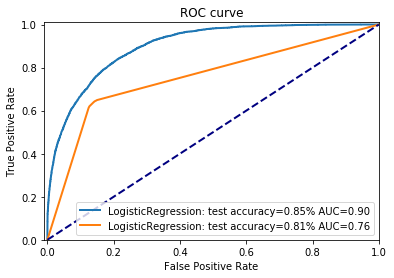

In [8]:
fig, ax = plt.subplots()

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# ROC curves
lab = 'LogisticRegression: test accuracy={:.2f}% AUC={:.2f}'.format(log_reg_test_acc, log_reg_auc)
ax.plot(log_reg_fpr, log_reg_tpr,
        lw=2, 
        label=lab) 

# ROC curves
lab = 'LogisticRegression: test accuracy={:.2f}% AUC={:.2f}'.format(tree_test_acc, tree_auc)
ax.plot(tree_fpr, tree_tpr,
        lw=2, 
        label=lab) 

# Plot the ROC curve associated to a coin flip
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])

plt.legend(loc='best')
          
plt.show()

**Questions:**

1. Explain how a ROC curve is computed.
2. What can the ROC curve be used for ?

**Bonus:** 
1. Think about a more compact way to reproduce the same plot (a loop might be a starting point).
2. You can also superimpose the results for `SVC`. Beware, the training phase may take some time.

In [ ]:
fig, ax = plt.subplots()

plt.title('ROC curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for clf in [DecisionTreeClassifier(),
            SVC(kernel='linear', probability=True)]:
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Evaluate the accuracy
    score = clf.score(X_test, y_test)
    
    # Build the Receiver Operating Characteristic curve:
    # 1: predict the probability to be classified as 1
    proba_pred_1 = clf.predict_proba(X_test)[:,1] # [:,1] to keep only P[y=1|X]
    # 2: compute false/true positive rates obtained by moving the detection threshold
    fpr, tpr, tresh = roc_curve(y_test, proba_pred_1)
    
    # Compute the Area Under the Curve
    eval_auc = auc(fpr, tpr)
    # roc_auc_score(y_test, proba_pred_1)
          
    # Associate a label to each classifier (don't spend time on it just use it)
    lab = ' '.join([clf.__class__.__name__,
                   'score {:.2f}'.format(score),
                   'AUC {:.2f}'.format(eval_auc)])
    
    # Plot the ROC curve
    ax.plot(fpr, tpr, label=lab, lw=2) 
    
# Plot the ROC curve associated to a coin flip
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

ax.xlim([0.0, 1.0])
ax.ylim([0.0, 1.05])

plt.legend(loc='best')
          
plt.show()

# Decision Trees

In this section, we focus on the `DecisionTreeClassifier` and strive to optimize its performances on our `census` dataset.

## Vizualization of shallow (low depth) trees

Consider `DecisionTreeClassifier(max_depth=)`

**Questions**

1. Display the trees corresponding to `max_depth` parameters in $\{1, 2, 3\}$ (have a look at the `Toy_Example` notebook).

2. Comment on these observations

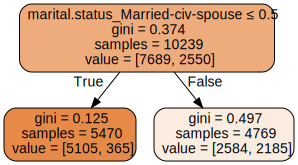

In [3]:
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X_train, y_train)

dot_data = export_graphviz(tree, out_file=None, 
                     feature_names=X_train.columns,  
#                      class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

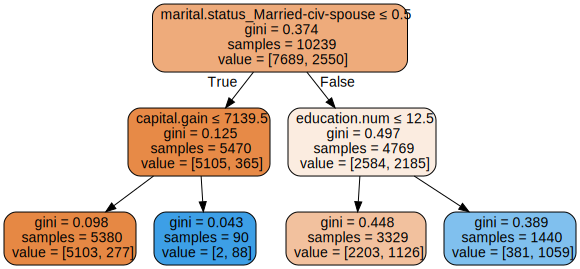

In [4]:
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train, y_train)

dot_data = export_graphviz(tree, out_file=None, 
                     feature_names=X_train.columns,  
#                      class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

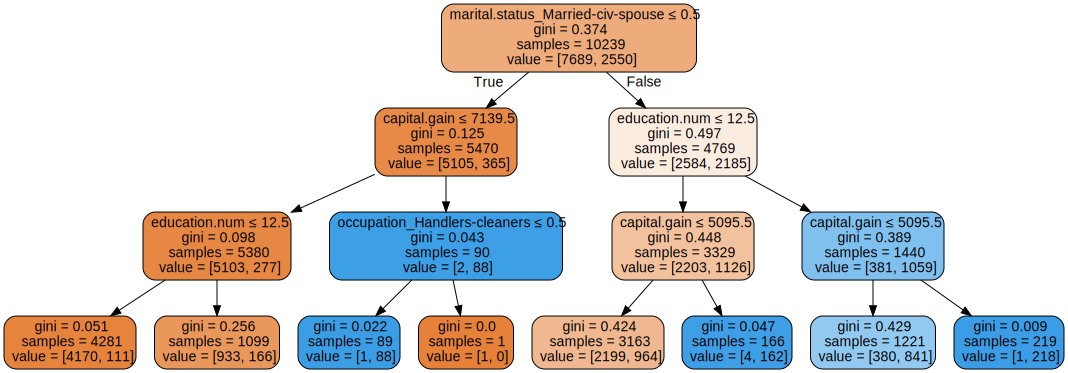

In [12]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train, y_train)

dot_data = export_graphviz(tree, out_file=None, 
                     feature_names=X_train.columns,  
#                      class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

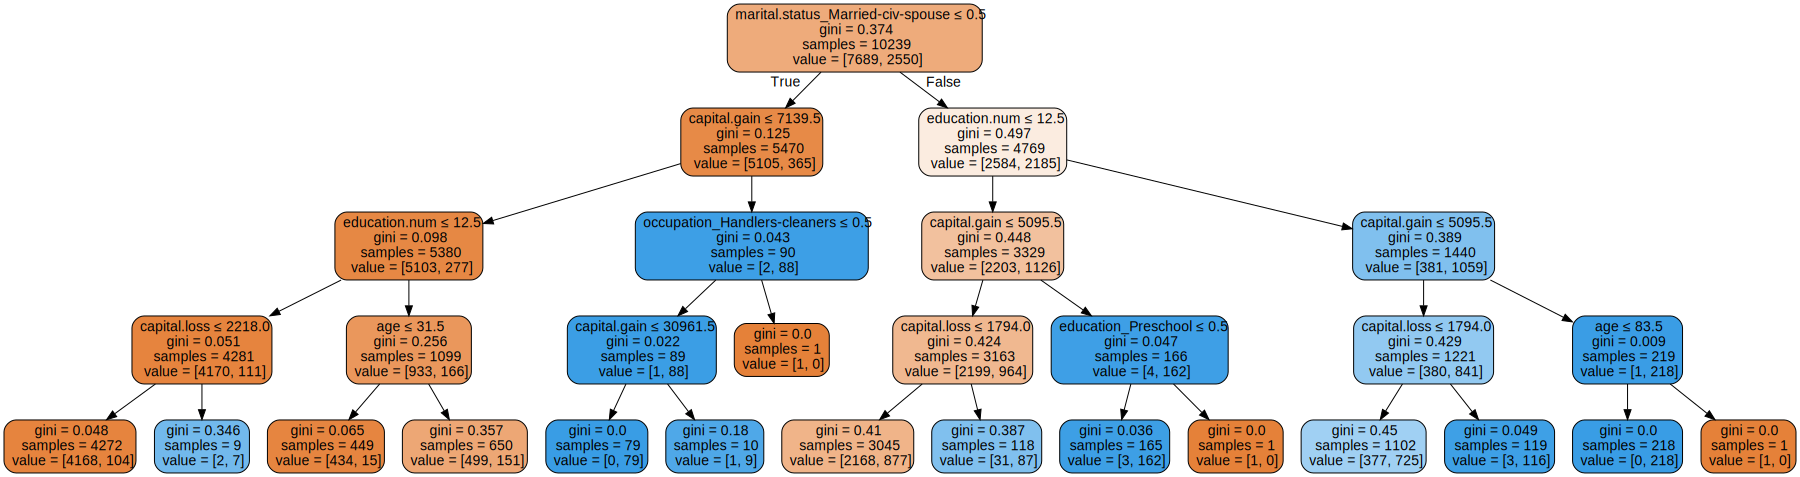

In [8]:
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train, y_train)

dot_data = export_graphviz(tree, out_file=None, 
                     feature_names=X_train.columns,  
#                      class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

## Bias-variance tradeoff 


Consider `DecisionTreeClassifier(max_depth=)`

**Questions**

For each `max_depth` $\in\{1,\dots, 15\}$.

1. Train the model on the full training set.
2. Save the corresponding training and test errors.
3. On a single plot, display the evolution of these errors with respect to `max_depth`.
4. Comment on the output plot.

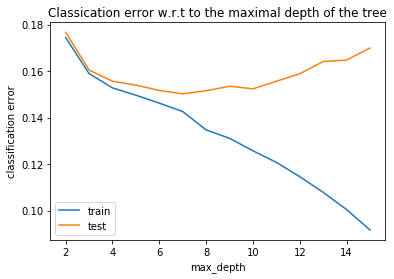

In [13]:
fig, ax = plt.subplots()

plt.title('Classication error w.r.t to the maximal depth of the tree')
plt.xlabel('max_depth')
plt.ylabel('classification error')

depths = np.arange(2, 15+1)
train_err = np.zeros(depths.size)
test_err = np.zeros(depths.size)

# tree = DecisionTreeClassifier()
for i, dep in enumerate(depths):
    
    tree = DecisionTreeClassifier(max_depth=dep)
#     tree.set_params(**{'max_depth'=dep})
    tree.fit(X_train, y_train)
    
    train_err[i] = 1.0 - tree.score(X_train, y_train)
    test_err[i] = 1.0 - tree.score(X_test, y_test)

ax.plot(depths, train_err, label='train')
ax.plot(depths, test_err, label='test')
    
plt.legend(loc='best')
          
plt.show()

## Optimization of the classifier with respect to classification error

### Preliminary

We are going to use the very convenient `GridSearchCV` method to tune our `DecisionTreeClassifier` in order improve our baseline.

1. Explain in a few words the purpose of cross validation and how it works.

As you should know by now there are many parameters that can be tuned to get better performance.

2. Take 3 parameters of the `DecisionTreeClassifier` and give their role.



### Let's practice

Let's start by optimizing `max_depth` alone.

In [19]:
grid = {'max_depth': np.arange(3, 20)}
cv = 5
scoring_rule = 'accuracy'
tree_grid = GridSearchCV(estimator=DecisionTreeClassifier(),
                         param_grid=grid,
                         cv=cv,
                         scoring=scoring_rule,
                         return_train_score=True)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
             pre_dis

Consider the attribute `tree_grid.cv_results_`

1. On the same plot, display the test and train cross-validation errors w.r.t. `max_depth`
2. What is the best value of `max_depth` in this case ?
3. Visualize the optimized decision tree.
4. Comment on these observations.

Step up to the next level by tuning multiple parameters at the same time with no extra effort!

5. In the same spirit, investigate different parameters and tune them separately.
6. Save the resulting classifier as `tree_opti_separate` and compute its error on the test set.
7. Use `GridSearchCV` to build the correponding grid of parameters 
8. Extract the best classifier associated to this grid of parameters and save it as `tree_opti_joint` (have a look at the `best_estimator_` attribute).
9. Give its performance on the test set

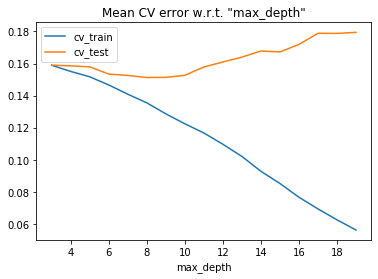

In [16]:
train_accuracy = tree_grid.cv_results_['mean_train_score']
test_accuracy = tree_grid.cv_results_['mean_test_score']

max_depth_range = grid['max_depth']

fig, ax = plt.subplots()

plt.title('Mean CV error w.r.t. "max_depth"')
plt.xlabel('max_depth')

ax.plot(max_depth_range, 1.0 - train_accuracy, label='cv_train')
ax.plot(max_depth_range, 1.0 - test_accuracy, label='cv_test')

plt.legend()
plt.show()

# SVMs

**Question**

With your own words, answer the following questions
1. What is a kernel for you?
2. In what context have you already met the kernel defined by $K(x,y)=\min(x,y)$?
3. What to you know about SVMs? (objective function, kernel trick, dual problem...)

Next, we turn to the optimization of the SVM.

4. Take 3 parameters of `SVC` and give their role.
5. Apply the recipe used for `DecisionTreeClassifier` to come up with an optimized SVM classier.

**Warning** training a SVM takes time, it scales as $\mathcal{O}(N^3)$ where $N$ is the number of training examples.

In [18]:
cv = 5
grid = [{'kernel': ['rbf'],
         'gamma': [1.0, 3.0],
         'C': [1.0]}]
svm_gs = GridSearchCV(estimator=SVC(),
                       param_grid=grid,
                       cv=cv,
                       return_train_score=True,
                       scoring='accuracy')

svm = SVC(kernel='rbf', gamma=1.0, C=1.0)

# features = ...
svm.fit(X_train, y_train)

svm_gs.fit(X_train, y_train)

svm_gs.cv_results_

{'mean_fit_time': array([6.45314775, 5.97489977]),
 'std_fit_time': array([1.00445543, 0.14583024]),
 'mean_score_time': array([1.11876454, 0.97518444]),
 'std_score_time': array([0.12210421, 0.01286512]),
 'param_C': masked_array(data=[1.0, 1.0],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[1.0, 3.0],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'rbf'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'},
  {'C': 1.0, 'gamma': 3.0, 'kernel': 'rbf'}],
 'split0_test_score': array([0.76123047, 0.75830078]),
 'split1_test_score': array([0.75830078, 0.75537109]),
 'split2_test_score': array([0.75292969, 0.75097656]),
 'split3_test_score': array([0.76025391, 0.75878906]),
 'split4_test_score': array([0.76160234, 0.75427455]),
 'mean_test_score'

# Conclusion

- Compare the performance of your optimized classifier to the baselines established in Section 3.

- Which classifier would you choose and why ?